# Assignment 3: Airline Economics
CEE260 Air Transportation  
Paul Sohn / March 31, 2016

In [101]:
% matplotlib inline
import pandas as pd, numpy as np, statsmodels.api as sm, matplotlib.pyplot as plt, scipy
from scipy.optimize import *
from __future__ import division
from patsy import dmatrices

## Problem Setup

Consider an O&D market of distance 1000 miles in which 500 hundred people want to fly each way per day. Your task is to choose:

* an aircraft type
* a fleet size, and
* a schedule

...in order to *minimize the total cost of travel in this market*, where the total cost of travel includes:

* Aircraft operating cost
* Aircraft ownership cost
* Aircraft servicing cost
* Air traveler schedule delay
* Air traveler flight time, and
* Air traveler stochastic delay.

## Objective Function and Constraints

Objective is to minimize total costs:

$$
Min TC = OwnCost + BlkHrCost + ACServCost + \alpha FltTime + \beta (SchedDelay + StochDelay)
$$

Where $\alpha$ is XYZ and $\beta$ is XYZ

We will estimate a cost function for each of the components of the total cost function in the sections below.

## Aircraft Cost

You will consider the following aircraft types:  
CRJ 700, a regional jet with 70 seats and a purchase price of about 23 million  
Airbus 319, a narrowbody jet with 128 seats and a purchase price of about 33 million

### Ownership costs

For purposes of this assignment, amortize the purchase price of the aircraft over 20 years, at 10 percent interest. Translate this to a daily cost assuming the aircraft is in service 300 days a year (it is out of service for maintenance the remaining time).

In order to get a daily cost, we can use the Equated Monthly Installment formula to determine the monthly cost, then total cost. 

$$ 
A = P * \frac{r(1+r)^n}{(1+r)^n - 1}
$$

where: P is the principal amount borrowed, A is the periodic amortization payment, r is the annual interest rate, and n is the total number of payments (20 years in this case).

In [2]:
# Costs of airplanes
cost_CRJ = 23000000
cost_airbus = 33000000
days = 300 * 20

# Function to return amortized total cost and calculate daily cost
def amortize(P,R,N):
    A = P * (R*(1+R)**N)/((1+R)**N -1)

    purchase = '${:,.2f}'.format(P)
    annual = '${:,.2f}'.format(A)
    total = '${:,.2f}'.format(A*N)
    daily = '${:,.2f}'.format((A*N)/days)
    
    print "Purchase Price: " + purchase
    print "Annual Cost: " + annual
    print "Total Cost: " + total
    print "Daily Cost: " + daily

In [3]:
# Cost of CRJ
amortize(cost_CRJ,.1,20)

Purchase Price: $23,000,000.00
Annual Cost: $2,701,571.37
Total Cost: $54,031,427.40
Daily Cost: $9,005.24


In [4]:
# Cost of Airbus
amortize(cost_airbus,.1,20)

Purchase Price: $33,000,000.00
Annual Cost: $3,876,167.62
Total Cost: $77,523,352.35
Daily Cost: $12,920.56


### Block hour costs

Use the data attached at the ends of this assignment. Base your costs on the airline industry average, and exclude ownership costs, since these are accounted for above. Recall that these are labeled “Aircraft Cost” in the data provided. To use the block hour cost data, you must find the block hours required to for a 1000-mile flight. To do this, note that the data includes, for each airline operating a given aircraft type, the average departures (i.e. flights) per day, the average block hours per day, and the average stage length per flight. Using these data, develop a regression model that enables you to estimate the block hours required for a 1000 mile flight. The model should yield an estimate of the “fixed” block hour cost entailed for a flight and the “variable” cost that depends on the stage length.

In [5]:
# Read in cost data
ac_costs = pd.read_csv("OperatingCosts.csv")
ac_costs.head()

We will use a linear regression to estimate the block hours required for a 1000 mile flight for different aircraft. The model is specified as follows:

$$
TotalBlockCost = \alpha + \beta_1 * CRJDummy + \beta_2 * StageLength
$$

For the TotalBlockCost term above, we will use average total cost per block hour, multiplied by block hours per departure, as calculated in the cell below by dividing average daily block hours by average number of departures for each airline. The CRJDummy term is a dummy variable to provide different values between aircraft. The StageLength term is average stage length for each airline.  

In [27]:
# Calculate block hours per departure
ac_costs["BH_per_dept"] = ac_costs.Day_BH / ac_costs.Day_Dept

# Calculate total block costs
ac_costs["Total_Block_Costs"] = ac_costs.Bl_Total * ac_costs.BH_per_dept

In [28]:
# Generate a simplifid dataset to run regression on 

BH_model = ac_costs[["Aircraft","Airline","Bl_Total","Total_Block_Costs","Op_StageLen","BH_per_dept"]]
BH_model

,Aircraft,Airline,Bl_Total,Total_Block_Costs,Op_StageLen,BH_per_dept
0,CRJ-700,Skywest,1870,3598.867925,652,1.924528
1,CRJ-700,Atlantic Southeast,1889,3692.136364,658,1.954545
2,CRJ-700,American Eagle,1592,2977.629630,614,1.870370
3,CRJ-700,Comair,1974,3819.260870,608,1.934783
4,CRJ-700,Horizon,2272,4158.188679,622,1.830189
5,CRJ-700,Mesa,1788,3192.857143,558,1.785714
6,CRJ-700,PSA,867,1184.492958,365,1.366197
7,A319,Northwest,2628,6110.100000,801,2.325000
8,A319,United,2991,9126.384615,1200,3.051282
9,A319,US Airways,3505,6866.938776,622,1.959184


In [29]:
# Specify OLS model

y, X = dmatrices("Total_Block_Costs ~ Op_StageLen + Aircraft", data=BH_model, return_type='dataframe')

In [30]:
# run regression and return parameters

mod = sm.OLS(y, X)
res = mod.fit() 
params = res.params
print params

Intercept              1927.358664
Aircraft[T.CRJ-700]   -2091.625461
Op_StageLen               5.831077
dtype: float64


These results tell us that:

* There is a fixed cost of \$1927 for a given flight
* There is a variable cost of \$5.83 per mile
* Total costs for CRJ-700 aircraft are \$2092 lower than for A319s.

In [33]:
# Calculate operating cost per 1000 miles for a CRJ-700

BlockCosts_CRJ = params[0] + (1000 * params[2]) + params[1]
print BlockCosts_CRJ

5666.8102564


In [34]:
# Calculate Block Costs per 1000 miles for an A319

BlockCosts_A319 = params[0] + (1000 * params[2])
print BlockCosts_A319

7758.4357172


### Aircraft Servicing Costs

Assume \$10 per seat-departure. 

In [36]:
# Servicing costs for one departure for each aircraft
serv_cost_CRJ = 70 * 10
serv_cost_A319 = 128 * 10
print serv_cost_CRJ, serv_cost_A319

700 1280


## Passenger Delay

Now that we have estimated aircraft costs, we can turn to passenger costs. 

### Travel Time

For purposes of this assignment, you can equate travel time with block time. While the total travel time includes airport access, check-in, security screening, etc. you can ignore these because they are not (strongly) affected by the decisions by the fleet and scheduling decisions you are making.

We can simply re-run the regression above, but instead of using total cost (block hours per departure * cost per block hour), we can simply estimate how many block hours it takes for different aircraft to travel 1000 miles.

In [37]:
y, X = dmatrices("BH_per_dept ~ Op_StageLen + Aircraft", data=BH_model, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit() 
params = res.params
print params

Intercept              0.784638
Aircraft[T.CRJ-700]   -0.072011
Op_StageLen            0.001883
dtype: float64


In [38]:
# Calculate operating cost per 1000 miles for a CRJ-700

BH_1000_CRJ = params[0] + (1000 * params[2]) + params[1]
BH_1000_A319 = params[0] + (1000 * params[2])
print "Block Hours for 1000 mile flight for CRJ: " + str(BH_1000_CRJ)
print "Block Hours for 1000 mile flight for A319: " + str(BH_1000_A319)

Block Hours for 1000 mile flight for CRJ: 2.5958596714
Block Hours for 1000 mile flight for A319: 2.66787102469


### Monetized Values of Time

According to Adler, Falzarano & Spitz (2005):

* Business travelers are willing to pay \$69.7 (each way) for each hour of reduction in trip time. Non-business travelers will pay, on average, a little less than half of that (\$31.2 per hour).
* Survey participants were asked to indicate their most preferred arrival time and flights were constructed with times
varying around that preferred time. The value assigned to the difference, on average, is about \$30.3/hour for business
travelers and only \$4.8/hour for non-business travelers. 

Although the latter value is specifically about arrival time and not departure time, we will use these values of time for schedule delay and stochastic delay.

### Schedule Delay

This is the difference between when a traveler would like to depart and when a flight is available. The distribution of travelers’ preferred time varies from market to market. For purposes of this assignment, use the distribution illustrated below, which is based on results from shuttle services between major East Coast cities. The figure gives the percentage of passengers whose preferred time is in each half hour period from 4-4:30 (!) to 24-0:30. The data presented in this chart are included in a spreadsheet accompanying the assignment.

In [96]:
# Create Departure Time Preference dataframe from excel file

DTP = pd.read_csv("Departure Time Preference.csv",index_col="Time",parse_dates=[0])
DTP.index = DTP.index.time
DTP.Pct = DTP.Pct / 100
DTP.CumPct = DTP.CumPct / 100

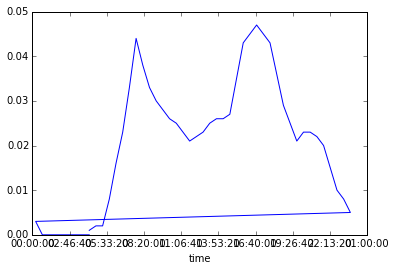

In [99]:
plt.plot(DTP.index,DTP.Pct)
plt.show()

In [100]:
DTP

,Pct,CumPct
04:15:00,0.001,0.001
04:45:00,0.002,0.003
05:15:00,0.002,0.005
05:45:00,0.008,0.013
06:15:00,0.016,0.029
06:45:00,0.023,0.052
07:15:00,0.033,0.085
07:45:00,0.044,0.129
08:15:00,0.038,0.167
08:45:00,0.033,0.200


In [ ]:
demand = 500
func = lambda x: 
result = minimize()